# TP1 - Vision Transformers - CEIA

Alumno: Isidro Marco Joel (a1520)

A continuación, trabajaremos con los **patch embeddings** y la **codificación posicional**, esenciales para que el modelo pueda interpretar las relaciones espaciales en las imágenes. 

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

## Modificar los parametros
Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

In [2]:
# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')
        
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()

Dispositivo utilizado: cuda


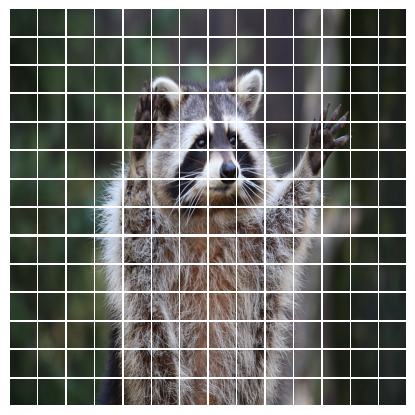

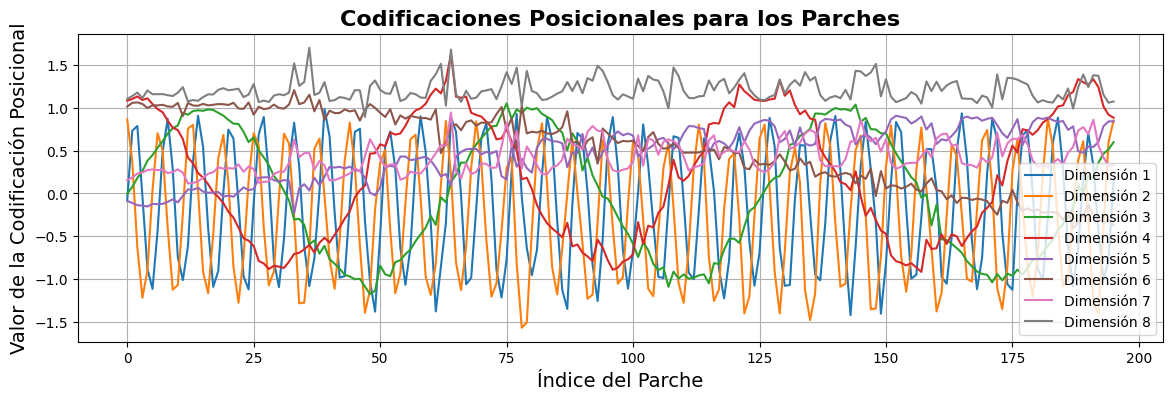

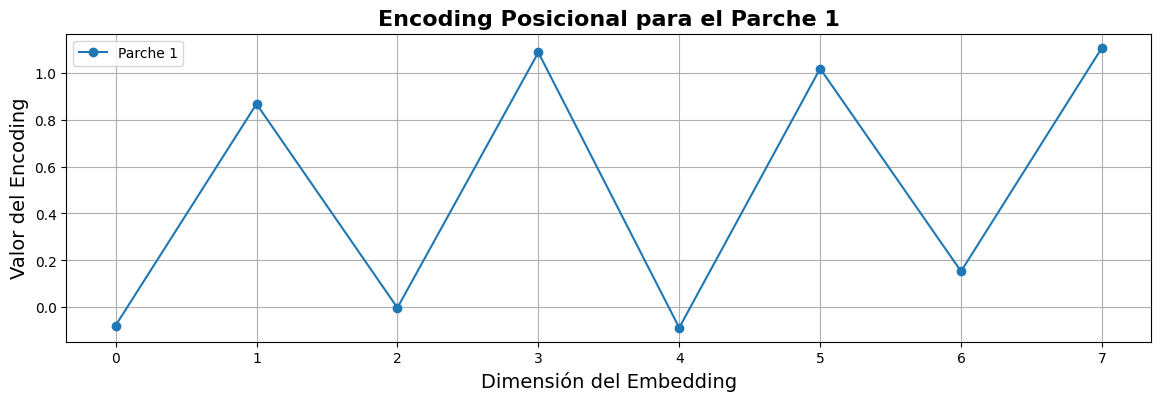

In [3]:
# Parámetros
img_path = "../../Images/raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

A continuación se va a realizar el mismo procesamiento para diferentes convinaciones de tamaño de parches y dimensiones.

################# PATCH SIZE 32 ###################
Dispositivo utilizado: cuda


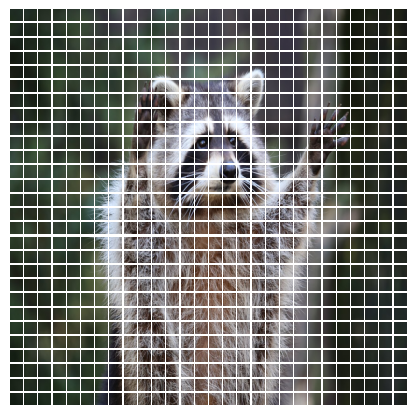

 --- EMBED DIM 2 ---


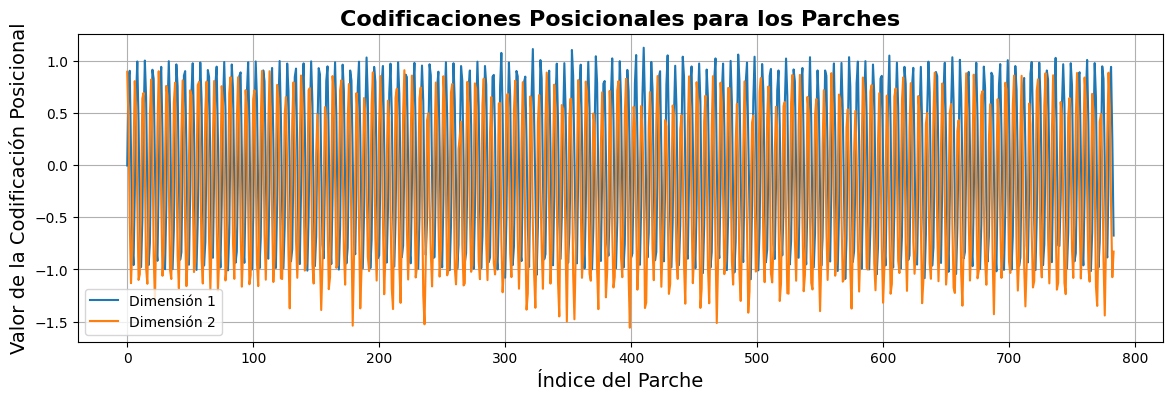

 --- EMBED DIM 4 ---


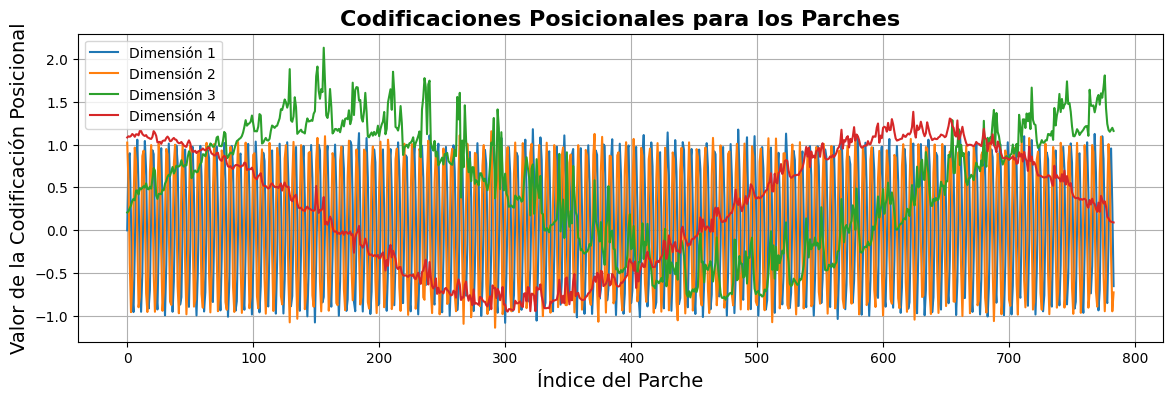

 --- EMBED DIM 8 ---


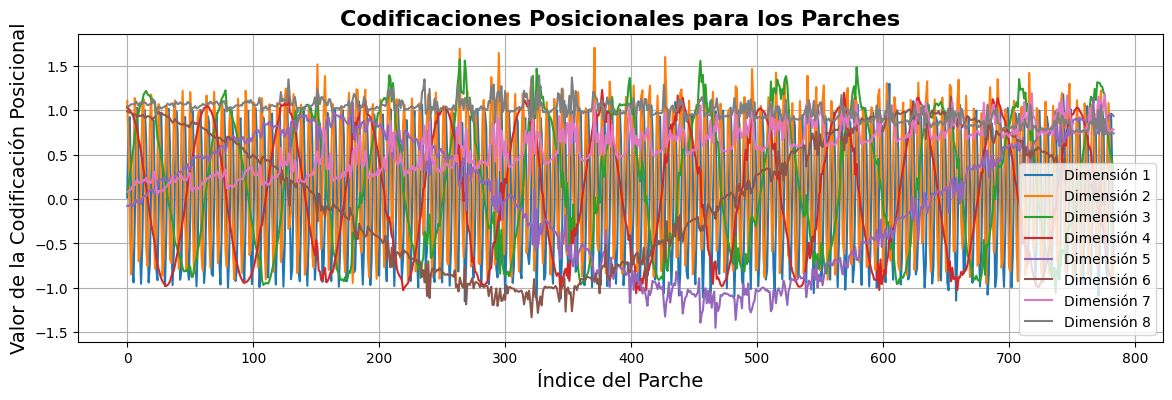

 --- EMBED DIM 16 ---


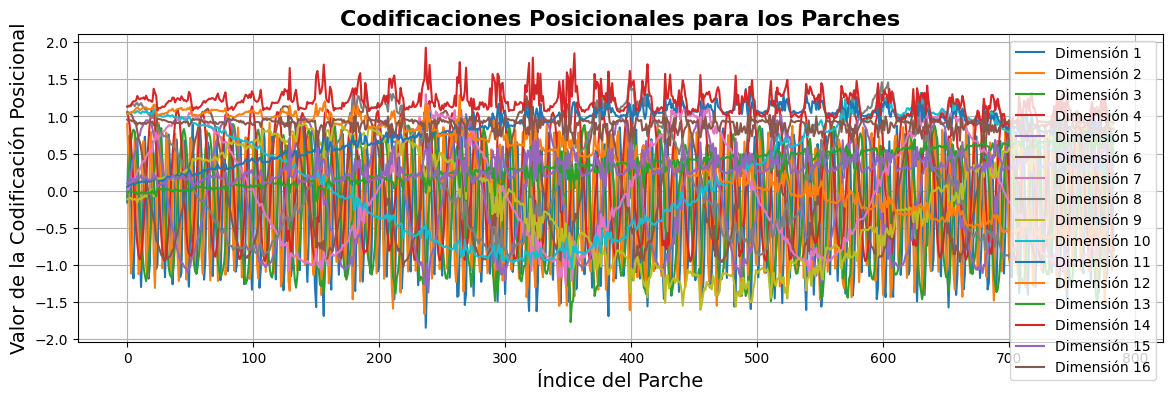

################# PATCH SIZE 64 ###################
Dispositivo utilizado: cuda


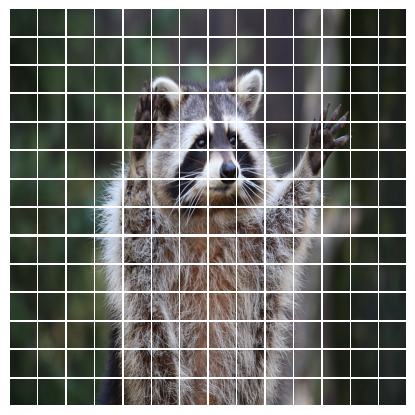

 --- EMBED DIM 2 ---


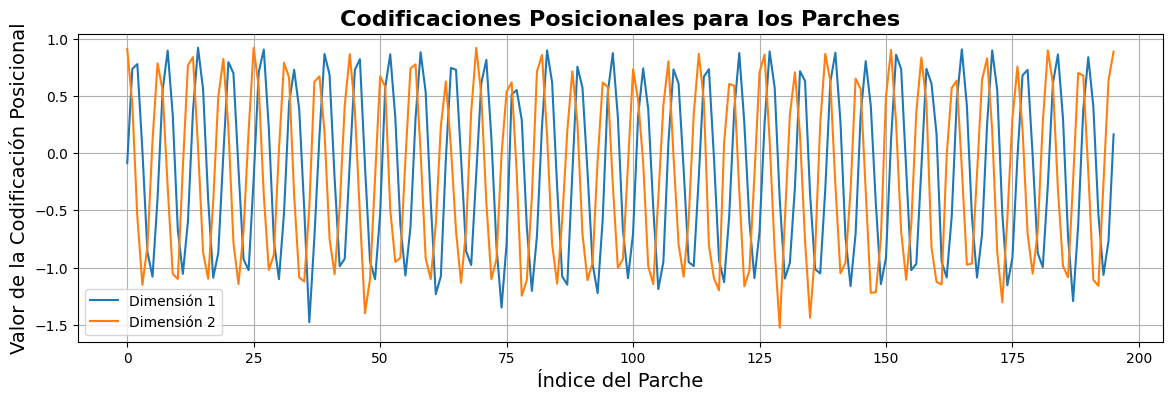

 --- EMBED DIM 4 ---


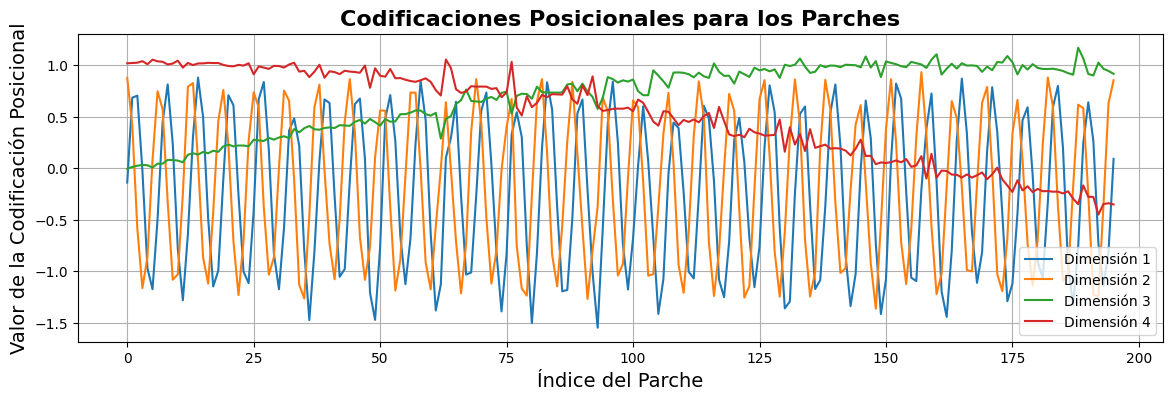

 --- EMBED DIM 8 ---


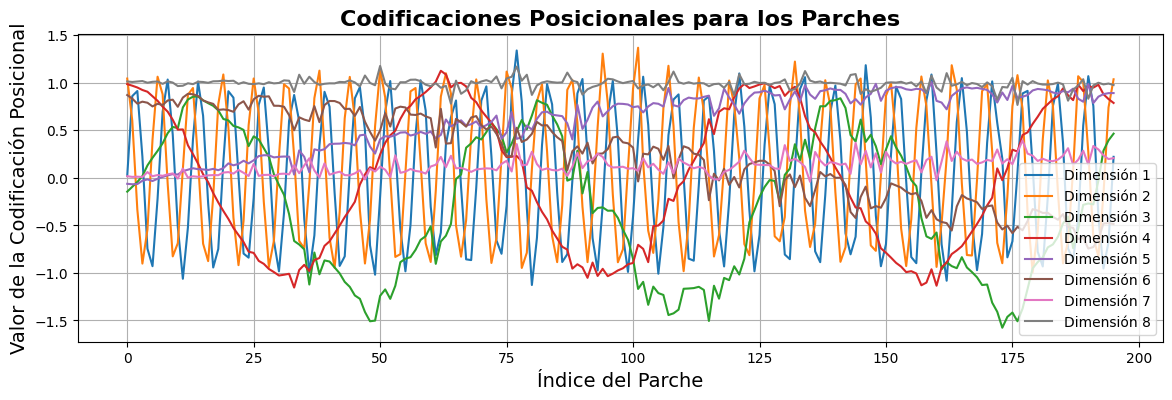

 --- EMBED DIM 16 ---


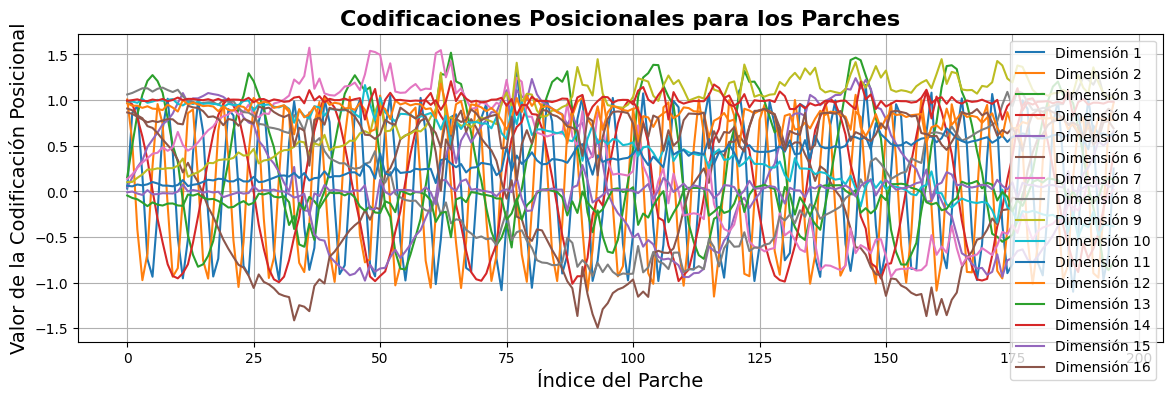

################# PATCH SIZE 128 ###################
Dispositivo utilizado: cuda


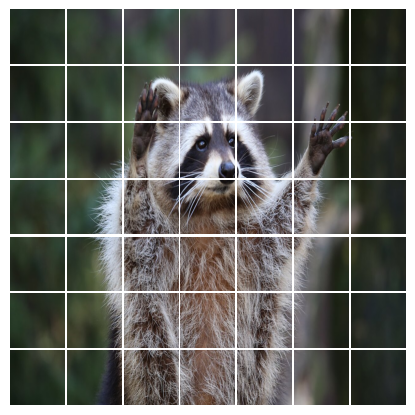

 --- EMBED DIM 2 ---


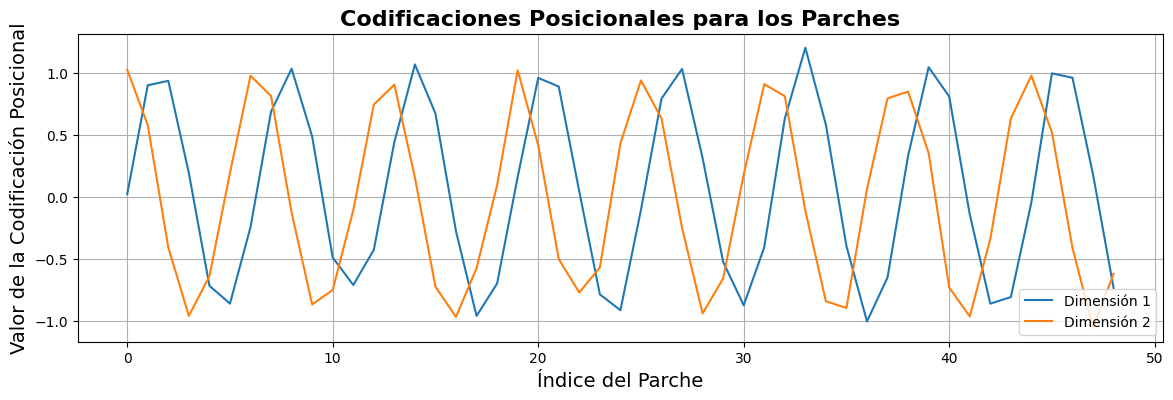

 --- EMBED DIM 4 ---


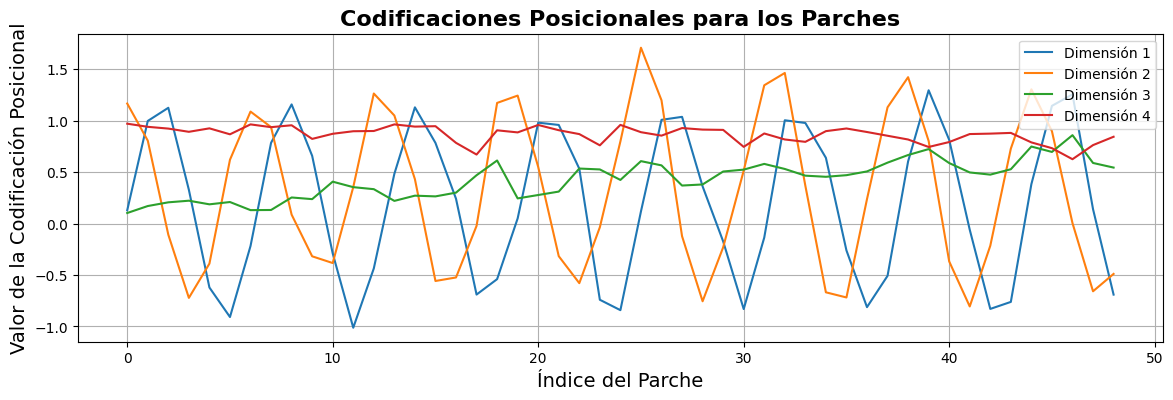

 --- EMBED DIM 8 ---


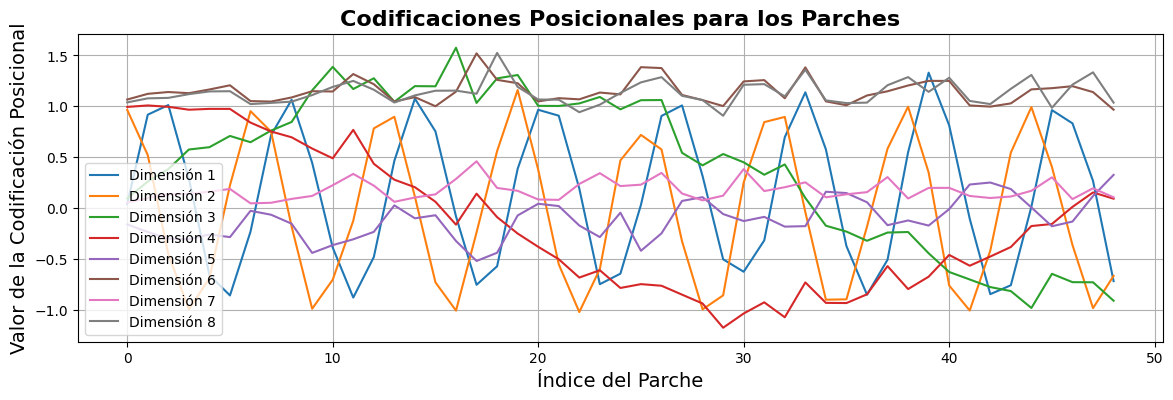

 --- EMBED DIM 16 ---


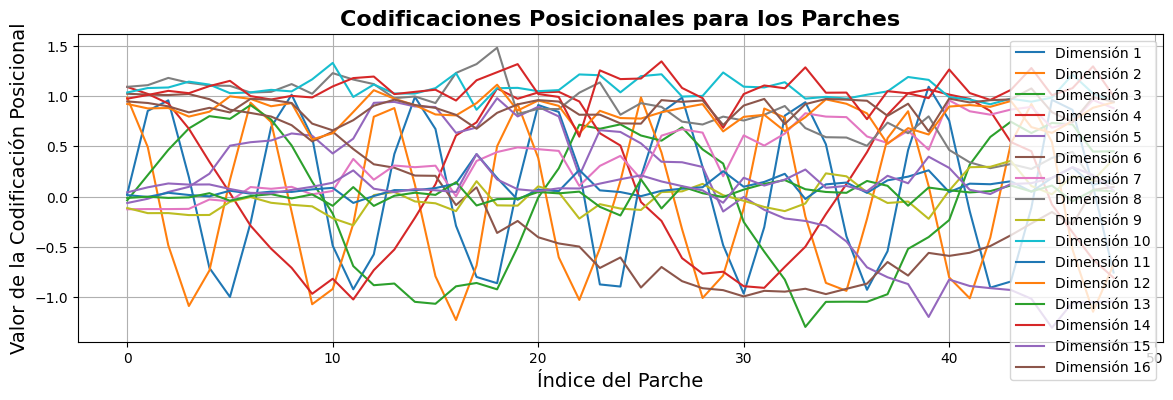

################# PATCH SIZE 256 ###################
Dispositivo utilizado: cuda


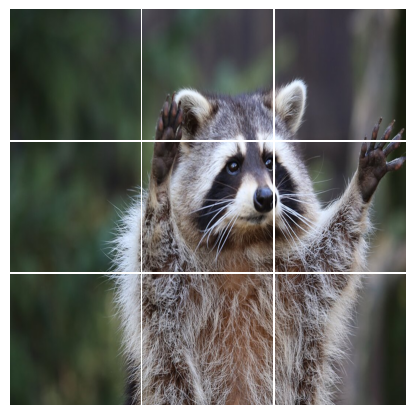

 --- EMBED DIM 2 ---


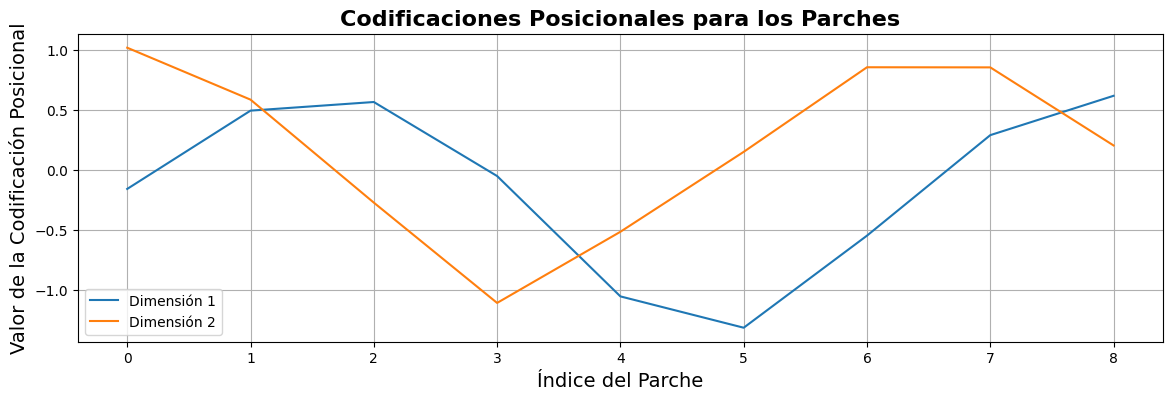

 --- EMBED DIM 4 ---


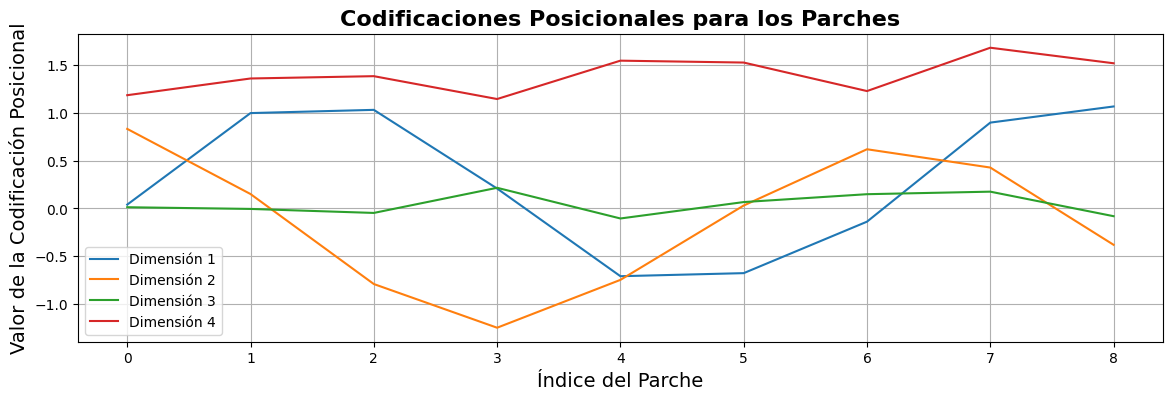

 --- EMBED DIM 8 ---


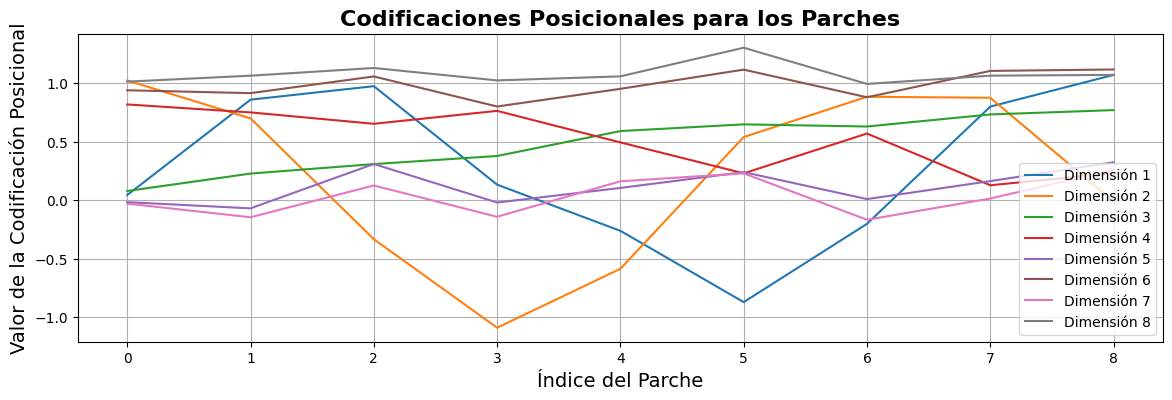

 --- EMBED DIM 16 ---


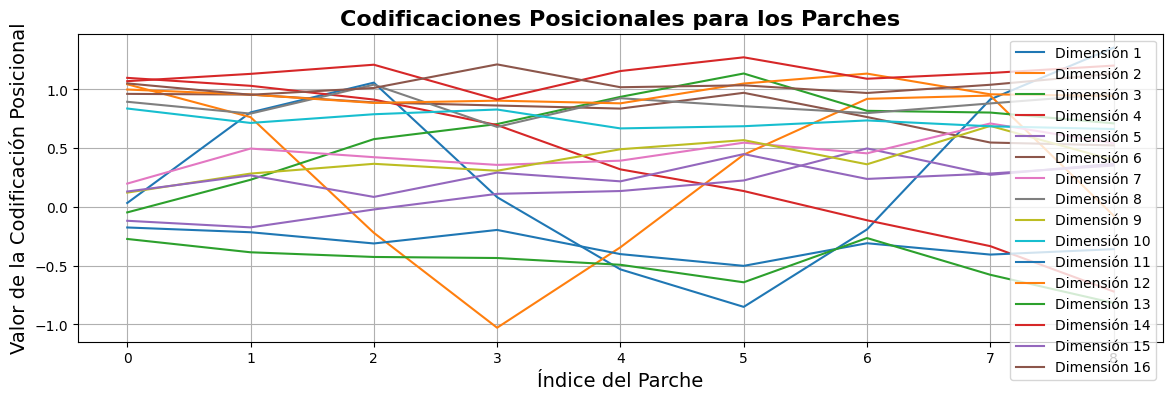

In [4]:
patch_sizes = [32,64,128,256]
embed_dims = [2,4,8,16]
img_path = "../../Images/raccoon.jpg"
img_size = 900

for patch_size in patch_sizes:
    for embed_dim in embed_dims:
        if embed_dim==2:
            print(f"################# PATCH SIZE {patch_size} ###################")
            config = ConfigPreprocess(img_path, img_size, patch_size)
            patches = config.extract_patches(config.test_img.squeeze(0))
            Visualization.visualize_patches(patches)

        print(f" --- EMBED DIM {embed_dim} ---")
        embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
        patches = embedded_patches(config.test_img)
        num_patches = (img_size // patch_size) ** 2
        positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
        pos_embeddings = positional_encoding(patches)
        Visualization.visualize_positional_encoding(pos_embeddings)

### Conclusiones

A continuación, se presentan las conclusiones obtenidas a partir del análisis realizado y del paper original sobre ViTs:

#### Tamaño de Parches

El aumento del tamaño de los parches genera una perdida de los detalles más finos en la imagen, pero a la ves que logra una mejor captura de patrones generales. Además al contar con una menor cantidad de parches el costo computacional se reduce.
Por otro lado, el trabajar con tamaños de parches más pequeños genera que se capturen más detalles mejorando la precisión, pero puede llegar a causar un sobreajuste. Además, trabajar con tamaños de parches muy chicos puede meter ruido al modelo.

#### Dimensión de Embeddings

Un aumento en la dimensión de los embeddings permite al modelo representar patrones más complejos y mejorar la precisión en tareas visuales, aunque incrementa el costo computacional y puede llevar al sobreajuste en conjuntos de datos específicos. 
En cambio, al reducir la dimensión de los embeddings, se obtiene un modelo más eficiente y menos propenso al sobreajuste; sin embargo, esto puede limitar su capacidad de representación en tareas complejas, comprometiendo la captura de patrones más detallados.

## Implementar embedding posicional aprendido 1D

Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 

In [5]:
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        # se inicializan como parámetros
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # se suman los embeddings a los parches
        return x + self.pos_embedding

Dispositivo utilizado: cuda


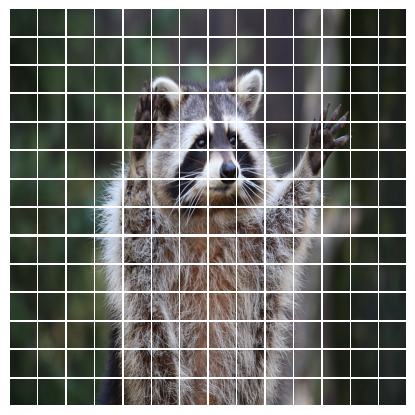

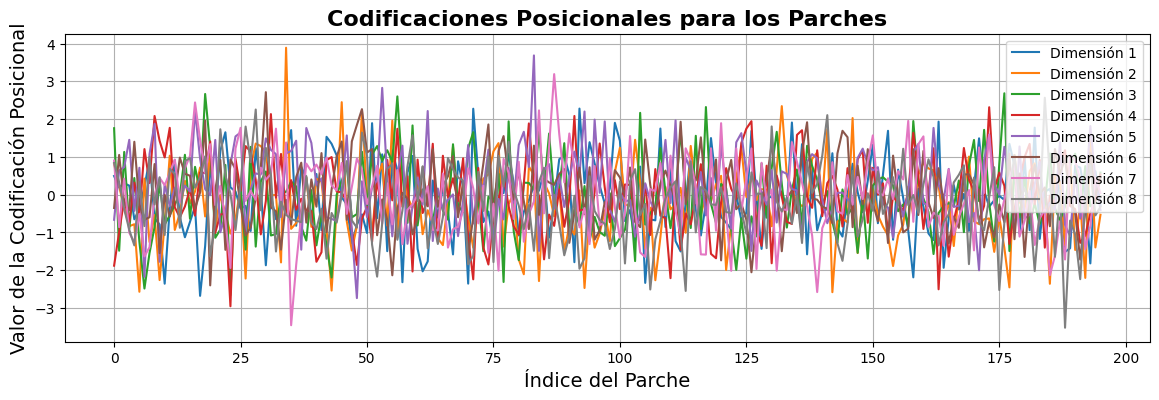

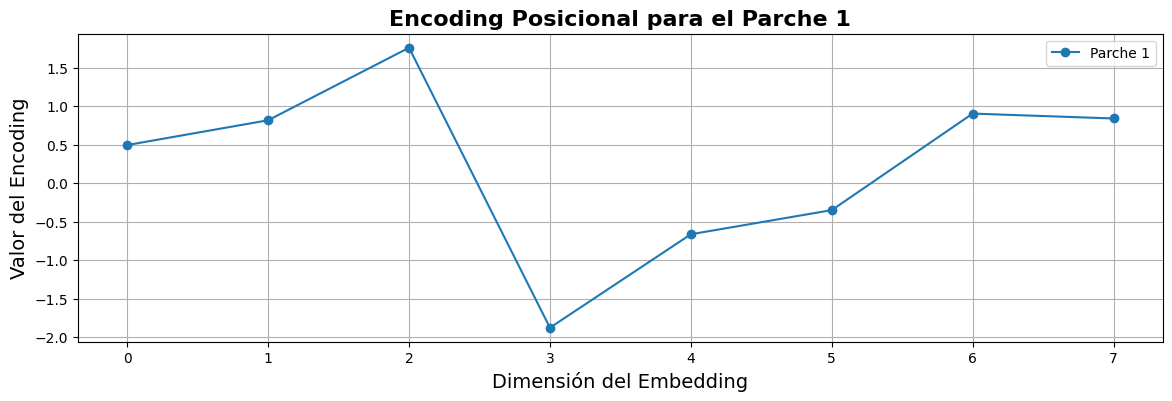

In [6]:
# Parámetros
img_path = "../../Images/raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

Como se puede observar, al estar inicializando los parametros de forma aleatoria, los mismos no siguen un patron osbervable, pero al trabajarse como parámetros se le da más versatilidad al modelo durante el entrenamiento.